# This Notebook contains all the methods used for prediction NSCLC

### Importing all required Libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import stats
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import pickle 
import joblib
import scipy
from scipy import stats
from imblearn.over_sampling import SMOTE 
import random
random.seed(2)
np.random.seed()
import xgboost as xgb
import plotly.graph_objects as go

### path to the files

In [2]:
training_dataset = '../datasets/training_data_after_feature_selection.csv'
test_dataset = '../datasets/test_data_after_feature_selection.csv'
logistic_regression_pretrained_weights = './pre-trained weights/logistic_regression_KFOLD_OVERSAMPLE.pkl'
decision_trees_weights = 'pre-trained weights/decision_trees_KFOLD_OVERSAMPLED.pkl'
SVM_weights = 'pre-trained weights/svm_KFOLD_OVERSAMPLED.pkl'
catboost_weights = 'pre-trained weights/catboost_KFOLD_OVERSAMPLING.pkl'
xgboost_weights = 'pre-trained weights/xgboost_KFOLD_OVERSAMPLING.pkl'
random_forest_weights = 'pre-trained weights/random_forest_KFOLD_OVERSAMPLING.pkl'
lgbm_weights = 'pre-trained weights/LGBM_KFOLDOVERSAMPLING.pkl'

### Importing the data-sets

In [3]:
train = pd.read_csv(training_dataset)
train.drop(['Unnamed: 0'],axis=1,inplace=True)
test = pd.read_csv(test_dataset)
test.drop(['Unnamed: 0'],axis=1,inplace=True)

### Outlier Removal using Z-Test followed by oversampling of the dataset with SMOTE

In [4]:
z = np.abs(stats.zscore(train))
threshold = 3
original_train = train
train = train[(z < 3).all(axis=1)]
train.columns
y = train['Disease Status (NSCLC: primary tumors; Normal: non-tumor lung tissues)']
x = train[train.columns[:-1]]
x = np.asarray(x)
y = np.asarray(y)
sm = SMOTE(random_state = 2) 

# Normal Classifiers

1. Logistic Regression
2. Decision Trees Classifiers
3. Support Vector Machines

#### Logistic Regression  

    params: 
        C=0.05827593122724494
        penalty='l1'
        solver='liblinear'
        tol=0.01, 
        max_iter=10,
        warm_start=True,
        intercept_scaling=10,
        random_state = 2

In [5]:
### load the weights
model_lr = joblib.load(logistic_regression_pretrained_weights)  
lr_val_auc = []
lr_val_kappa = []
print('Training and checking cross-validation scores\n')
skf = StratifiedKFold(n_splits=5, random_state=42)
fold = 1
for train_index, val_index in skf.split(x,y): 
    X_train, X_test = x[train_index], x[val_index] 
    Y_train, Y_test = y[train_index], y[val_index]
    X_train, Y_train = sm.fit_sample(X_train, Y_train.ravel())
    a_train = model_lr.predict(X_train)
    a_test = model_lr.predict(X_test)
    print('K-FOLD #',fold)
    fold+=1
    print('Train AUC-ROC Score: ',roc_auc_score(Y_train,a_train),' Val AUC-ROC score: ',roc_auc_score(Y_test,a_test),'\n')
    print('validation kappa:-',cohen_kappa_score(Y_test,a_test))
    lr_val_auc.append(roc_auc_score(Y_test,a_test))
    lr_val_kappa.append(cohen_kappa_score(Y_test,a_test))
    
print('Here we go with the confision Matrix\n')
print(confusion_matrix(Y_test,a_test))
print(classification_report(Y_test,a_test))
print('\n')
print('........................Testing the Model..............................\n')
y_testt = test['Disease Status (NSCLC: primary tumors; Normal: non-tumor lung tissues)']
x_testt = test[test.columns[:-1]]
y_testt_pred = model_lr.predict(x_testt)

a_test = []
for i in y_testt_pred:
    if i>0.5:
        a_test.append(1)
    else:
        a_test.append(0)

print('0:- NSCLC Detected', '\t& \t1:- Normal\n')

print('Here we go with the confision Matrix\n')
print(confusion_matrix(y_testt,a_test))
print(classification_report(y_testt,a_test))

print('test kappa: \t',cohen_kappa_score(y_testt, a_test))

print('test AUC-ROC score: \t',roc_auc_score(y_testt, a_test))

lr_test_auc = roc_auc_score(y_testt, a_test)
lr_test_kappa = cohen_kappa_score(y_testt, a_test)

Training and checking cross-validation scores

K-FOLD # 1
Train AUC-ROC Score:  0.9640410958904109  Val AUC-ROC score:  0.972972972972973 

validation kappa:- 0.9057301293900185
K-FOLD # 2
Train AUC-ROC Score:  0.9675767918088737  Val AUC-ROC score:  0.944969296173831 

validation kappa:- 0.8807854137447405
K-FOLD # 3
Train AUC-ROC Score:  0.9590443686006827  Val AUC-ROC score:  0.9931506849315068 

validation kappa:- 0.9755625453665618
K-FOLD # 4
Train AUC-ROC Score:  0.9726962457337884  Val AUC-ROC score:  0.9383561643835616 

validation kappa:- 0.7976852882261296
K-FOLD # 5
Train AUC-ROC Score:  0.9658703071672355  Val AUC-ROC score:  0.9547455968688846 

validation kappa:- 0.8804167653327019
Here we go with the confision Matrix

[[69  4]
 [ 1 27]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97        73
           1       0.87      0.96      0.92        28

    accuracy                           0.95       101
   macro avg       0

#### Decision Trees Classifiers (DTC)

    params: 
    class_weight=None, 
    criterion='gini', 
    max_depth=int(10),
    max_features=int(10.4),
    min_samples_leaf=int(10), 
    min_samples_split=2,
    random_state=42, 
    splitter='best'

In [6]:
model_dtc = joblib.load(decision_trees_weights) 

dtc_val_auc = []
dtc_val_kappa = []

skf = StratifiedKFold(n_splits=5, random_state=42)

# X is the feature set and y is the target
fold = 1
for train_index, val_index in skf.split(x,y): 
    X_train, X_test = x[train_index], x[val_index] 
    Y_train, Y_test = y[train_index], y[val_index]
    
    X_train, Y_train = sm.fit_sample(X_train, Y_train.ravel())
    
    a_train = model_dtc.predict(X_train)
    a_test = model_dtc.predict(X_test)
    print('K-FOLD #',fold)
    fold+=1
    print('Train AUC-ROC Score: ',roc_auc_score(Y_train,a_train),' Val AUC-ROC score: ',roc_auc_score(Y_test,a_test),'\n')

    print('val kappa:-',cohen_kappa_score(Y_test,a_test))
    
    dtc_val_auc.append(roc_auc_score(Y_test,a_test))
    dtc_val_kappa.append(cohen_kappa_score(Y_test,a_test))

print(confusion_matrix(Y_test,a_test))
print(classification_report(Y_test,a_test))
print('\n')
print('........................Testing the Model..............................\n')
y_testt = test['Disease Status (NSCLC: primary tumors; Normal: non-tumor lung tissues)']
x_testt = test[test.columns[:-1]]
y_testt_pred = model_dtc.predict(x_testt)

a_test = []
for i in y_testt_pred:
    if i>0.5:
        a_test.append(1)
    else:
        a_test.append(0)

print('0:- NSCLC Detected', '\t& \t1:- Normal\n')

print('Here we go with the confision Matrix\n')
print(confusion_matrix(y_testt,a_test))
print(classification_report(y_testt,a_test))

print('test kappa: \t',cohen_kappa_score(y_testt, a_test))
print('test AUC-ROC score: \t',roc_auc_score(y_testt, a_test))

dtc_test_auc = roc_auc_score(y_testt, a_test)
dtc_test_kappa = cohen_kappa_score(y_testt, a_test)

K-FOLD # 1
Train AUC-ROC Score:  0.9092465753424656  Val AUC-ROC score:  0.9194015444015444 

val kappa:- 0.8295942720763723
K-FOLD # 2
Train AUC-ROC Score:  0.9163822525597269  Val AUC-ROC score:  0.9208786017949929 

val kappa:- 0.8330995792426368
K-FOLD # 3
Train AUC-ROC Score:  0.9010238907849828  Val AUC-ROC score:  0.9684442270058709 

val kappa:- 0.9266876360996854
K-FOLD # 4
Train AUC-ROC Score:  0.9232081911262799  Val AUC-ROC score:  0.858610567514677 

val kappa:- 0.725204056393767
K-FOLD # 5
Train AUC-ROC Score:  0.9215017064846417  Val AUC-ROC score:  0.8806262230919766 

val kappa:- 0.7369168837319441
[[66  7]
 [ 4 24]]
              precision    recall  f1-score   support

           0       0.94      0.90      0.92        73
           1       0.77      0.86      0.81        28

    accuracy                           0.89       101
   macro avg       0.86      0.88      0.87       101
weighted avg       0.90      0.89      0.89       101



........................Testi

#### Support Vector Machines (SVM)

    params: 
        kernel='linear',
        gamma = 82, 
        C = 1.4555047314930398

In [7]:
model_svm = joblib.load(SVM_weights)
svm_val_auc = []
svm_val_kappa = []
k_fold = 5
skf = StratifiedKFold(n_splits=k_fold, random_state=42)
fold = 1
for train_index, val_index in skf.split(x,y):  
    X_train, X_test = x[train_index], x[val_index] 
    Y_train, Y_test = y[train_index], y[val_index]
    
    X_train, Y_train = sm.fit_sample(X_train, Y_train.ravel())
    
    a_train = model_svm.predict(X_train)
    a_test = model_svm.predict(X_test)
    print('K-FOLD #',fold)
    fold+=1
        
    a_test1 = []
    for i in a_test:
        if i>0.5:
            a_test1.append(1)
        else:
            a_test1.append(0)
    
    a_train1 = []
    for i in a_train:
        if i>0.5:
            a_train1.append(1)
        else:
            a_train1.append(0)
    
    
    print('Train AUC-ROC Score: ',roc_auc_score(a_train1,Y_train),' Val AUC-ROC score: ',roc_auc_score(Y_test,a_test1),'\n')
    print('validation kappa:-',cohen_kappa_score(Y_test,a_test1))
    svm_val_auc.append(roc_auc_score(Y_test,a_test1))
    svm_val_kappa.append(cohen_kappa_score(Y_test,a_test1))
    

print(confusion_matrix(Y_test,a_test1))
print(classification_report(Y_test,a_test1))
print('\n')
print('........................Testing the Model..............................\n')
y_testt = test['Disease Status (NSCLC: primary tumors; Normal: non-tumor lung tissues)']
x_testt = test[test.columns[:-1]]
y_testt_pred = model_svm.predict(x_testt)

a_test = []
for i in y_testt_pred:
    if i>0.5:
        a_test.append(1)
    else:
        a_test.append(0)

print('0:- NSCLC Detected', '\t& \t1:- Normal\n')

print('Here we go with the confision Matrix\n')
print(confusion_matrix(y_testt,a_test))
print(classification_report(y_testt,a_test))

print('test kappa: \t',cohen_kappa_score(y_testt, a_test))
print('test AUC-ROC score: \t',roc_auc_score(y_testt,a_test))


svm_test_auc = roc_auc_score(y_testt,a_test)
svm_test_kappa = cohen_kappa_score(y_testt, a_test)

K-FOLD # 1
Train AUC-ROC Score:  0.9749891359242686  Val AUC-ROC score:  1.0 

validation kappa:- 1.0
K-FOLD # 2
Train AUC-ROC Score:  0.9750723217618514  Val AUC-ROC score:  1.0 

validation kappa:- 1.0
K-FOLD # 3
Train AUC-ROC Score:  0.9750723217618514  Val AUC-ROC score:  1.0 

validation kappa:- 1.0
K-FOLD # 4
Train AUC-ROC Score:  0.9865521541025253  Val AUC-ROC score:  0.9410469667318982 

validation kappa:- 0.8360769765824252
K-FOLD # 5
Train AUC-ROC Score:  0.9881967747949293  Val AUC-ROC score:  0.9341976516634052 

validation kappa:- 0.8145938503900871
[[66  7]
 [ 1 27]]
              precision    recall  f1-score   support

           0       0.99      0.90      0.94        73
           1       0.79      0.96      0.87        28

    accuracy                           0.92       101
   macro avg       0.89      0.93      0.91       101
weighted avg       0.93      0.92      0.92       101



........................Testing the Model..............................

0:- NSCLC

# Ensemble Classifiers

1. CATBOOST (GPU Powered)
2. Random Forest
3. XGBOOST
4. LGBM

#### CATBOOST

    params:
        loss_function= 'Logloss',
        iterations = 300,
        learning_rate=.01,
        max_depth=10, 
        eval_metric = 'AUC',
        leaf_estimation_iterations = 10,
        task_type="GPU",
        devices='0-6'

In [8]:
model_ctb = joblib.load(catboost_weights) 
CBT_val_auc = []
CBT_val_kappa = []
kfold = 5
np.random.seed(2)
skf = StratifiedKFold(n_splits=kfold, random_state=42)

fold = 1
for train_index, val_index in skf.split(x,y): 
    X_train, X_test = x[train_index], x[val_index] 
    Y_train, Y_test = y[train_index], y[val_index]
    
    X_train, Y_train = sm.fit_sample(X_train, Y_train.ravel())
    
    a_train = model_ctb.predict(X_train)
    a_test = model_ctb.predict(X_test)
    print('K-FOLD #',fold)
    fold+=1
    print('Train AUC-ROC Score: ',roc_auc_score(Y_train,a_train),' Val AUC-ROC score: ',roc_auc_score(Y_test,a_test),'\n')
    print('validation kappa:-',cohen_kappa_score(Y_test,a_test))
    
    
    
    CBT_val_auc.append(roc_auc_score(Y_test,a_test))
    CBT_val_kappa.append(roc_auc_score(Y_test,a_test))

K-FOLD # 1
Train AUC-ROC Score:  0.9811643835616437  Val AUC-ROC score:  1.0 

validation kappa:- 1.0
K-FOLD # 2
Train AUC-ROC Score:  0.9863481228668942  Val AUC-ROC score:  1.0 

validation kappa:- 1.0
K-FOLD # 3
Train AUC-ROC Score:  0.9880546075085326  Val AUC-ROC score:  1.0 

validation kappa:- 1.0
K-FOLD # 4
Train AUC-ROC Score:  0.9948805460750852  Val AUC-ROC score:  0.950587084148728 

validation kappa:- 0.901174168297456
K-FOLD # 5
Train AUC-ROC Score:  0.9914675767918089  Val AUC-ROC score:  0.9684442270058709 

validation kappa:- 0.9266876360996854


### confusion matrix for catboost model on validation dataset

In [9]:
print(confusion_matrix(Y_test,a_test))
print(classification_report(Y_test,a_test))

[[71  2]
 [ 1 27]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        73
           1       0.93      0.96      0.95        28

    accuracy                           0.97       101
   macro avg       0.96      0.97      0.96       101
weighted avg       0.97      0.97      0.97       101



### confusion matrix for catboost model on test dataset

In [10]:
y_testt = test['Disease Status (NSCLC: primary tumors; Normal: non-tumor lung tissues)']
x_testt = test[test.columns[:-1]]
y_test_test = model_ctb.predict(x_testt)
print('0:- NSCLC Detected', '\t& \t1:- Normal\n')
print(confusion_matrix(y_testt,y_test_test))
print(classification_report(y_testt,y_test_test))

print('test kappa:-',cohen_kappa_score(y_testt, y_test_test))
print('test AUC-ROC score',roc_auc_score(y_testt,y_test_test))


CBT_test_auc = roc_auc_score(y_testt, y_test_test)
CBT_test_kappa = cohen_kappa_score(y_testt, y_test_test)

0:- NSCLC Detected 	& 	1:- Normal

[[199   0]
 [  9  10]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       199
           1       1.00      0.53      0.69        19

    accuracy                           0.96       218
   macro avg       0.98      0.76      0.83       218
weighted avg       0.96      0.96      0.95       218

test kappa:- 0.6698081454055873
test AUC-ROC score 0.763157894736842


#### Random Forest

    params:
        n_estimators=int(10.27)
        bootstrap = True
        max_depth = 3
        max_features = 8
        max_leaf_nodes = 17
        n_jobs = 9
        random_state = 42

In [11]:
model_rf = joblib.load(random_forest_weights) 
RFC_val_auc = []
RFC_val_kappa = []
skf = StratifiedKFold(n_splits=5, random_state=42)
# X is the feature set and y is the target
fold = 1
for train_index, val_index in skf.split(x,y): 
    #print("Train:", train_index, "Validation:", val_index) 
    X_train, X_test = x[train_index], x[val_index] 
    Y_train, Y_test = y[train_index], y[val_index]
    
    X_train, Y_train = sm.fit_sample(X_train, Y_train.ravel())  
    a_train = model_rf.predict(X_train)
    a_test = model_rf.predict(X_test)
    print('K-FOLD #',fold)
    fold+=1
    print('Train AUC-ROC Score: ',roc_auc_score(Y_train,a_train),' Val AUC-ROC score: ',roc_auc_score(Y_test,a_test),'\n')
    print('validation kappa:-',cohen_kappa_score(Y_test,a_test))    
    RFC_val_auc.append(roc_auc_score(Y_test,a_test))
    RFC_val_kappa.append(roc_auc_score(Y_test,a_test))
print(confusion_matrix(Y_test,a_test))
print(classification_report(Y_test,a_test))
print('\n')
print('........................Testing the Model..............................\n')
y_testt = test['Disease Status (NSCLC: primary tumors; Normal: non-tumor lung tissues)']
x_testt = test[test.columns[:-1]]
y_testt_pred = model_rf.predict(x_testt)

a_test = []
for i in y_testt_pred:
    if i>0.5:
        a_test.append(1)
    else:
        a_test.append(0)

print('0:- NSCLC Detected', '\t& \t1:- Normal\n')

print('Here we go with the confision Matrix\n')
print(confusion_matrix(y_testt,a_test))
print(classification_report(y_testt,a_test))

print('test kappa: \t',cohen_kappa_score(y_testt, a_test))
print('test AUC-ROC score: \t',roc_auc_score(y_testt,a_test))
RFC_test_auc = roc_auc_score(y_testt, a_test)
RFC_test_kappa = cohen_kappa_score(y_testt, a_test)

K-FOLD # 1
Train AUC-ROC Score:  0.958904109589041  Val AUC-ROC score:  0.9551158301158301 

validation kappa:- 0.8808967772069126
K-FOLD # 2
Train AUC-ROC Score:  0.9607508532423208  Val AUC-ROC score:  0.9586679263108171 

validation kappa:- 0.9269689737470167
K-FOLD # 3
Train AUC-ROC Score:  0.9522184300341298  Val AUC-ROC score:  0.9931506849315068 

validation kappa:- 0.9755625453665618
K-FOLD # 4
Train AUC-ROC Score:  0.9829351535836178  Val AUC-ROC score:  0.8764677103718199 

validation kappa:- 0.75293542074364
K-FOLD # 5
Train AUC-ROC Score:  0.9573378839590443  Val AUC-ROC score:  0.9931506849315068 

validation kappa:- 0.9755625453665618
[[72  1]
 [ 0 28]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        73
           1       0.97      1.00      0.98        28

    accuracy                           0.99       101
   macro avg       0.98      0.99      0.99       101
weighted avg       0.99      0.99      0.99       10

#### XGBOOST

    params: {
        'min_child_weight': 10.0,
        'lambda': 0.3397604475560514,
        'objective': 'binary:logistic',
        'max_depth': 20,
        'alpha': 5.7154910613882356e-05,
        'max_delta_step': 0.1,
        'eta': 0.1673343679061888,
        'colsample_bytree': 0.4,
        'subsample': 0.8,
        'eta': 0.1673343679061888,
        'gamma': 1.019025732933819e-06,
        'grow_policy': 'depthwise',
        'eval_metric' : 'auc',
        'silent': 1,
        'num_boost_round' : 700,
    }

In [12]:
kfold = 5
skf = StratifiedKFold(n_splits=kfold, random_state=42)
model_xgb = joblib.load(xgboost_weights) 
XGB_val_auc = []
XGB_val_kappa = []
for i, (train_index, test_index) in enumerate(skf.split(x, y)):
    print('[Fold %d/%d]' % (i + 1, kfold))
    X_train, X_valid = x[train_index], x[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    X_train, y_train = sm.fit_sample(X_train, y_train.ravel())    
    # Convert our data into XGBoost format
    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')] 
    a_train = model_xgb.predict(d_train)
    a_valid = model_xgb.predict(d_valid)
    
    at = []
    for i in a_train:
        if i>0.6:
            at.append(1)
        else:
            at.append(0)
    
    
    a = []
    for i in a_valid:
        if i>0.6:
            a.append(1)
        else:
            a.append(0)
    print('train AUC-ROC:-',roc_auc_score(y_train, at))
    print('val AUC-ROC:-',roc_auc_score(y_valid, a))
    print('val kappa:-',cohen_kappa_score(y_valid, a))
    print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))
    XGB_val_auc.append(roc_auc_score(y_valid, a))
    XGB_val_kappa.append(roc_auc_score(y_valid, a))

[Fold 1/5]
train AUC-ROC:- 0.9828767123287672
val AUC-ROC:- 0.972972972972973
val kappa:- 0.9057301293900185
[Fold 1/5 Prediciton:]
[Fold 2/5]
train AUC-ROC:- 0.9778156996587031
val AUC-ROC:- 0.9655172413793103
val kappa:- 0.9507959479015919
[Fold 1/5 Prediciton:]
[Fold 3/5]
train AUC-ROC:- 0.9761092150170649
val AUC-ROC:- 1.0
val kappa:- 1.0
[Fold 1/5 Prediciton:]
[Fold 4/5]
train AUC-ROC:- 0.9846416382252561
val AUC-ROC:- 0.950587084148728
val kappa:- 0.901174168297456
[Fold 1/5 Prediciton:]
[Fold 5/5]
train AUC-ROC:- 0.9812286689419795
val AUC-ROC:- 0.9684442270058709
val kappa:- 0.9266876360996854
[Fold 1/5 Prediciton:]


### testing on independent test data set using XGBOOST

In [13]:
y_testt = test['Disease Status (NSCLC: primary tumors; Normal: non-tumor lung tissues)']
x_testt = test[test.columns[:-1]]
x_testt = xgb.DMatrix(np.array(x_testt),y_testt)
y_testt_pred = model_xgb.predict(x_testt)

a_test = []
for i in y_testt_pred:
    if i>0.6:
        a_test.append(1)
    else:
        a_test.append(0)
print('0:- NSCLC Detected', '\t& \t1:- Normal\n')
print(confusion_matrix(y_testt,a_test))
print(classification_report(y_testt,a_test))
print('test kappa:-',cohen_kappa_score(y_testt, a_test))
print('test AUC-ROC score',roc_auc_score(y_testt,a_test))
XGB_test_auc = roc_auc_score(y_testt,a_test)
XGB_test_kappa = cohen_kappa_score(y_testt,a_test)

0:- NSCLC Detected 	& 	1:- Normal

[[199   0]
 [  0  19]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       199
           1       1.00      1.00      1.00        19

    accuracy                           1.00       218
   macro avg       1.00      1.00      1.00       218
weighted avg       1.00      1.00      1.00       218

test kappa:- 1.0
test AUC-ROC score 1.0


#### LGBM:

    params: 
        iterations = 1000,
        subsample=.8,
        learning_rate=.1,
        max_depth=10, max_delta_step = 0.1, alpha = 5.71, min_child_weight = 10, eta = 0.167, cosample_bytree = 0.4,
        num_boost_round = 700

In [14]:
kfold = 5
skf = StratifiedKFold(n_splits=kfold, random_state=42)
model_lgb = joblib.load(lgbm_weights) 
LGB_val_auc = []
LGB_val_kappa = []
fold = 1
for train_index, val_index in skf.split(x,y): 
    X_train, X_test = x[train_index], x[val_index] 
    Y_train, Y_test = y[train_index], y[val_index]
    X_train, Y_train = sm.fit_sample(X_train, Y_train.ravel())
    a_train = model_lgb.predict(X_train)
    a_test = model_lgb.predict(X_test)
    print('K-FOLD #',fold)
    fold+=1
    print('Train AUC-ROC Score: ',roc_auc_score(Y_train,a_train),' Val AUC-ROC score: ',roc_auc_score(Y_test,a_test),'\n')
    print('validation kappa:-',cohen_kappa_score(Y_test,a_test))
    LGB_val_auc.append(roc_auc_score(Y_test,a_test))
    LGB_val_kappa.append(roc_auc_score(Y_test,a_test))

K-FOLD # 1
Train AUC-ROC Score:  0.9743150684931506  Val AUC-ROC score:  0.9797297297297297 

validation kappa:- 0.9285380663241476
K-FOLD # 2
Train AUC-ROC Score:  0.9744027303754266  Val AUC-ROC score:  0.9827586206896552 

validation kappa:- 0.9756563245823389
K-FOLD # 3
Train AUC-ROC Score:  0.9744027303754266  Val AUC-ROC score:  1.0 

validation kappa:- 1.0
K-FOLD # 4
Train AUC-ROC Score:  0.9880546075085324  Val AUC-ROC score:  0.9300391389432485 

validation kappa:- 0.8325834714657826
K-FOLD # 5
Train AUC-ROC Score:  0.9744027303754266  Val AUC-ROC score:  0.9684442270058709 

validation kappa:- 0.9266876360996854


### Testing LGBM on independent test data-set

In [15]:
y_testt = test['Disease Status (NSCLC: primary tumors; Normal: non-tumor lung tissues)']
x_testt = test[test.columns[:-1]]
y_testt_pred = model_lgb.predict(x_testt)

a_test = []
for i in y_testt_pred:
    if i>0.6:
        a_test.append(1)
    else:
        a_test.append(0)
print('0:- NSCLC Detected', '\t& \t1:- Normal\n')
print(confusion_matrix(y_testt,a_test))
print(classification_report(y_testt,a_test))
print('test kappa:-',cohen_kappa_score(y_testt, a_test))
print('test AUC-ROC score',roc_auc_score(y_testt,a_test))

LGB_test_auc = roc_auc_score(y_testt,a_test)
LGB_test_kappa = cohen_kappa_score(y_testt,a_test)

0:- NSCLC Detected 	& 	1:- Normal

[[197   2]
 [  0  19]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       199
           1       0.90      1.00      0.95        19

    accuracy                           0.99       218
   macro avg       0.95      0.99      0.97       218
weighted avg       0.99      0.99      0.99       218

test kappa:- 0.944963393082555
test AUC-ROC score 0.9949748743718593


# Visualization of comparision among different models

In [33]:
import plotly
colors = plotly.colors.DEFAULT_PLOTLY_COLORS.copy()

# Create the basic figure and add data
fig = go.Figure()

fig.add_trace(
	go.Box(
    y = lr_val_auc,
		name = 'Logistic Regression',
    marker_color = colors[0],
		boxpoints = 'all',
		pointpos = -1.5,
		jitter = 0.2,
	)
)

fig.add_trace(
	go.Box(
    y = dtc_val_auc,
		name = 'Decision Trees',
    marker_color = colors[1],
		boxpoints = 'all',
		pointpos = -1.5,
		jitter = 0.2,
	)
)

fig.add_trace(
	go.Box(
    y=svm_val_auc,
		name='SVM',
    marker_color = colors[2], #'#FF851B'
		boxpoints = 'all',
		pointpos = -1.5,
		jitter = 0.2,
	)
)

fig.add_trace(
	go.Box(
    y=CBT_val_auc,
		name='CatBoost',
    marker_color = colors[3], #'#FF907B'
		boxpoints = 'all',
		pointpos = -1.5,
		jitter = 0.2,
	)
)

fig.add_trace(
	go.Box(
    y=RFC_val_auc,
		name='Random Forest',
    marker_color = colors[4], #'pink'
		boxpoints = 'all',
		pointpos = -1.5,
		jitter = 0.2,
))

fig.add_trace(go.Box(
    y=XGB_val_auc,
		name='XGBoost',
    marker_color= colors[5], #'yellow'
		boxpoints = 'all',
		pointpos = -1.5,
		jitter = 0.2,
))

fig.add_trace(go.Box(
    y=LGB_val_auc,
		name='LightBoost',
    marker_color= colors[6], #'grey'
		boxpoints = 'all',
		# pointpos = 5,
		jitter = 0.2,
))

In [25]:
fig.update_layout(
	# title = 'Validation AUC-ROC Comparison',
	plot_bgcolor = 'white',

	xaxis = dict(
		mirror = True,
		linecolor = 'black',
		gridcolor = 'ghostwhite',
		ticks = 'outside',
	),	

  yaxis = dict(
		title='Validation AUC-ROC Score',
		gridcolor = 'ghostwhite',
		linecolor = 'black',
		side = 'left',
		range = [0.8, 1.01],
		mirror = True,
	),

	boxmode='group',
	showlegend=False
)

fig.update_traces(
	width = 0.6,
)

# fig.show()
# # fig
# fig.write_image('./Results/Validation AUC-ROC comparision.jpeg', width=2.5*300, height=2*300, scale=10)
# fig.write_image('aurc.eps', scale=5)

In [39]:
fig2 = go.Figure()

traces = [lr_val_kappa, dtc_val_kappa, svm_val_kappa, CBT_val_kappa, RFC_val_kappa, XGB_val_kappa, LGB_val_kappa ]
tNames = ['Logistic Regression','Decision Trees', 'SVM', 'CatBoost', 'Random Forest', 'XGBoost', 'LightBoost' ]

for i, t in enumerate(traces):
	fig2.add_trace(
	go.Box(
    y=t,
		x = [i]*len(t),
    name=tNames[i],
		marker_color= colors[i],
		boxpoints='all',
		pointpos=0,
		jitter=0.2,
		width = 0.6
))



fig2.update_layout(
	# title="Validation Kappa comparision",
	plot_bgcolor = 'white',
	xaxis = dict(
		mirror = True,
		linecolor = 'black',
		gridcolor = 'ghostwhite',
		ticks = 'outside'
	),
  yaxis = dict(
		title='Validation Kappa score',
    mirror = True,
		linecolor = 'black',
		gridcolor = 'ghostwhite',
		side = 'left',
		range = [0.7, 1.01]
	),
	boxmode='group',
  showlegend=False
)


# fig2.write_image('./Results/Validation Kappa comparision.jpeg', width=2.5*300, height=2*300, scale=10)

ValueError: 
    Invalid value of type 'builtins.int' received for the 'x' property of box
        Received value: 0

    The 'x' property is an array that may be specified as a tuple,
    list, numpy array, or pandas Series

In [18]:

x = ['Logistic Regression','Decision Trees','SVM','CatBoost', 'RANDOM FOREST', 'XGBoost','LightBoost']
y = [lr_test_auc,dtc_test_auc,svm_test_auc,CBT_test_auc,RFC_test_auc, XGB_test_auc, LGB_test_auc]

# Use the hovertext kw argument for hover text
fig = go.Figure(data=[go.Bar(x=x, y=y)])
# Customize aspect
fig.update_traces(marker_color=['blue','red','#FF851B','#FF907B','pink','yellow','grey'], marker_line_color='rgb(255,255,255)',
                  marker_line_width=1.5, opacity=0.5)
fig.update_layout(title_text='AUC-ROC comparision on Independent Test data',font=dict(
        family="Courier New, monospace",
        size=15,
        color="Black"
    ))
fig.show()

fig.write_image('./Results/AUC-ROC comparision on Independent Test data.jpeg', width=2.5*300, height=2*300, scale=10)

In [19]:

x = ['Logistic Regression','Decision Trees','SVM','CatBoost', 'RANDOM FOREST', 'XGBoost','LightBoost']
y = [lr_test_kappa,dtc_test_kappa,svm_test_kappa,CBT_test_kappa,RFC_test_kappa, XGB_test_kappa, LGB_test_kappa]

# Use the hovertext kw argument for hover text
fig = go.Figure(data=[go.Bar(x=x, y=y)])
# Customize aspect
fig.update_traces(marker_color=['blue','red','#FF851B','#FF907B','pink','yellow','grey'], marker_line_color='rgb(255,255,255)',
                  marker_line_width=1.5, opacity=0.5)
fig.update_layout(title_text='Kappa comparision on Independent Test data',font=dict(
        family="Courier New, monospace",
        size=15,
        color="Black"))
fig.show()

fig.write_image('./Results/Kappa comparision on Independent Test data.jpeg', width=2.5*300, height=2*300, scale=10)

### AUC-ROC curves of Normal classifiers

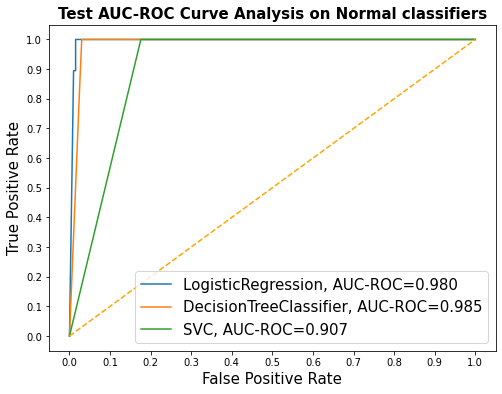

In [20]:
y_testt = test['Disease Status (NSCLC: primary tumors; Normal: non-tumor lung tissues)']
x_testt = test[test.columns[:-1]]



# Instantiate the classfiers and make a list
classifiers = [model_lr, 
               model_dtc, 
               model_svm]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    yproba = cls.predict_proba(x_testt)[::,1]
    
    fpr, tpr, _ = roc_curve(y_testt,  yproba)
    
    
    yproba = cls.predict(x_testt)
    auc = roc_auc_score(y_testt,yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC-ROC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('Test AUC-ROC Curve Analysis on Normal classifiers', fontweight='bold', fontsize=15)
plt.legend(prop={'size':15}, loc='lower right')

plt.show()

fig.savefig('./Results/Test AUC-ROC Curve Analysis on Normal classifiers.jpeg', dpi=600, bbox_inches='tight')

### AUC-ROC comparision on Ensemble Classifiers

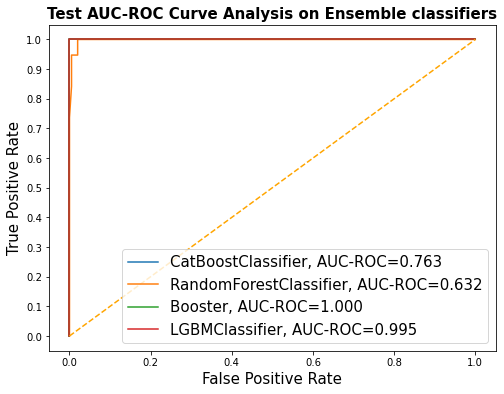

In [21]:
y_testt = test['Disease Status (NSCLC: primary tumors; Normal: non-tumor lung tissues)']
x_testt = test[test.columns[:-1]]

# Instantiate the classfiers and make a list
classifiers = [model_ctb, 
               model_rf, 
               model_xgb,model_lgb]

c = [1,1,0,1]
f = 0
# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    
    if(c[f] ==0):
        x_testtt = xgb.DMatrix(np.array(x_testt),y_testt)     
        yproba = cls.predict(x_testtt)
        fpr, tpr, _ = roc_curve(y_testt,  yproba)
        y_proba1 = []
        for i in yproba:
            if i>0.6:
                y_proba1.append(1)
            else:
                y_proba1.append(0)
        
        
        auc = roc_auc_score(y_testt,y_proba1)
      
        
    else:

        yproba = cls.predict_proba(x_testt)[::,1]

        fpr, tpr, _ = roc_curve(y_testt,  yproba)

        yproba = cls.predict(x_testt)
        auc = roc_auc_score(y_testt,yproba)

    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

    f+=1
        
# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC-ROC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('Test AUC-ROC Curve Analysis on Ensemble classifiers', fontweight='bold', fontsize=15)
plt.legend(prop={'size':15}, loc='lower right')

plt.show()

fig.savefig('./Results/Test AUC-ROC Curve Analysis on Ensemble classifiers.jpeg', dpi=600, bbox_inches='tight')

## Building AUC-ROC curves on the validation dataset

#### Normal classifiers

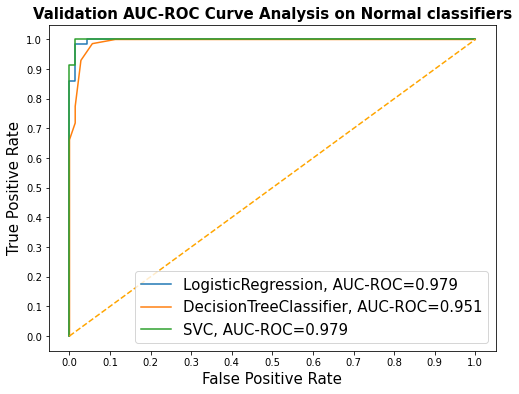

In [22]:
y = train['Disease Status (NSCLC: primary tumors; Normal: non-tumor lung tissues)']
x = train[train.columns[:-1]]
x = np.asarray(x)
y = np.asarray(y)

X_train, X_val, y_train, Y_val = train_test_split(x, y, test_size=0.2, random_state=42)

x_testt, y_testt = sm.fit_sample(X_val, Y_val.ravel())
# Instantiate the classfiers and make a list
classifiers = [model_lr, 
               model_dtc, 
               model_svm]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    yproba = cls.predict_proba(x_testt)[::,1]
    
    fpr, tpr, _ = roc_curve(y_testt,  yproba)
    
    
    yproba = cls.predict(x_testt)
    auc = roc_auc_score(y_testt,yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC-ROC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('Validation AUC-ROC Curve Analysis on Normal classifiers', fontweight='bold', fontsize=15)
plt.legend(prop={'size':15}, loc='lower right')

plt.show()

fig.savefig('./Results/Validation AUC-ROC Curve Analysis on Normal classifiers.jpeg', dpi=600, bbox_inches='tight')

### Ensemble Classifiers

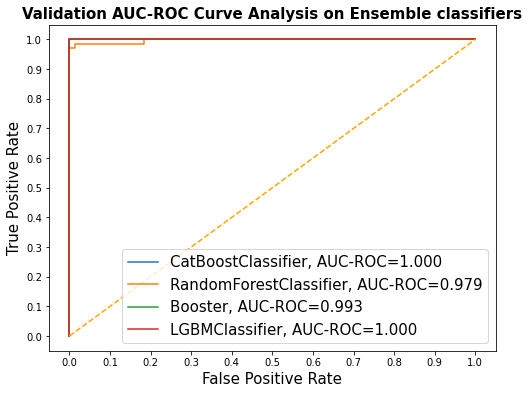

In [23]:
y = train['Disease Status (NSCLC: primary tumors; Normal: non-tumor lung tissues)']
x = train[train.columns[:-1]]
x = np.asarray(x)
y = np.asarray(y)

X_train, X_val, y_train, Y_val = train_test_split(x, y, test_size=0.2, random_state=42)

x_testt, y_testt = sm.fit_sample(X_val, Y_val.ravel())
# Instantiate the classfiers and make a list
classifiers = [model_ctb, 
               model_rf, 
               model_xgb,model_lgb]

c = [1,1,0,1]
f = 0
# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    
    if(c[f] ==0):
        x_testtt = xgb.DMatrix(np.array(x_testt),y_testt)
        yproba = cls.predict(x_testtt)

        fpr, tpr, _ = roc_curve(y_testt,  yproba)
        y_proba1 = []
        for i in yproba:
            if i>0.6:
                y_proba1.append(1)
            else:
                y_proba1.append(0)
        
        
        auc = roc_auc_score(y_testt,y_proba1)
      
        
    else:

        yproba = cls.predict_proba(x_testt)[::,1]

        fpr, tpr, _ = roc_curve(y_testt,  yproba)

        yproba = cls.predict(x_testt)
        auc = roc_auc_score(y_testt,yproba)

    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

    f+=1
        
# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC-ROC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('Validation AUC-ROC Curve Analysis on Ensemble classifiers', fontweight='bold', fontsize=15)
plt.legend(prop={'size':15}, loc='lower right')

plt.show()

fig.savefig('./Results/Validation AUC-ROC Curve Analysis on Ensemble classifiers.jpeg', dpi=600, bbox_inches='tight')